# Simulating hiring interviews
This notebook provides sample [EDSL](https://docs.expectedparrot.com/) code for simulating hiring interviews using large language models. We show 2 different ways of doing this:

#### Using question prompts
In the first example we prompt a language model to create an interview dialog between a freelancer candidate and a client hiring for a job, and then prompt the model to pretend it is each of the client and freelancer in the interview and rate the other party's performance. We give the model a sample job post and freelancer background to reference in generating the dialog. We do this for all combinations of 10 hypothetical job posts and 10 freelancer backgrounds (100 in total). We also use a preliminary question prompting the agent to skip the dialog and performance rating questions if the freelancer is not at all qualified for the job.

#### Using AI agents
In the second example we construct personas for AI agents representing the client and freelancer in each of the dialogs, tell them that they were the participants in the dialogs, and then prompt them to rate each other's performance. This is different from the first example where we instructed the model to draft the dialog and then pretend to be either the client or freelancer with knowledge that it had created the dialog (we give it the full context of the dialog question prompt). This time, we simply give the dialog to the agents representing the client and freelancers and then instruct them to do the ratings.

### EDSL
EDSL is an open-source library for simulating surveys and experiments with AI agents and language models. Please see our [documentation page](https://docs.expectedparrot.com/) for tips and tutorials on getting started.

We start by importing the tools that we will use to simulate the interviews. EDSL comes with a [variety of question types](https://docs.expectedparrot.com/en/latest/questions.html) that we can choose from based on the form of the response that we want to get back from the model (multiple choice, free text, etc.). Here we will use a free text question to prompt the model to generate dialogs and a linear scale question for eliciting the ratings of the client and freelancer:

In [1]:
from edsl import ScenarioList

sl = ScenarioList.from_sqlite("onet.db", "occupation_data").sample(2)
sl.print()

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ onetsoc_code ┃ title                            ┃ description                                                   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 51-6092.00   │ Fabric and Apparel Patternmakers │ Draw and construct sets of precision master fabric patterns   │
│              │                                  │ or layouts. May also mark and cut fabrics and apparel.        │
├──────────────┼──────────────────────────────────┼───────────────────────────────────────────────────────────────┤
│ 17-2171.00   │ Petroleum Engineers              │ Devise methods to improve oil and gas extraction and          │
│              │                                  │ production and determine the need for new or modified tool    │
│              │                                  │ designs. Oversee drilling and offer technical advice.         │
└──────────────┴──────────────────────────────────┴───────────────────────────────────────────────────────────────┘

In [2]:
from edsl import QuestionFreeText

q = QuestionFreeText(
    question_text="Please create an example job post for this title and job description: {{title}}: {{ description }}",
    question_name="job_post",
)
# results = q.by(sl).run(progress_bar = True, cache = False)

In [3]:
from edsl.questions import QuestionYesNo, QuestionFreeText, QuestionLinearScale
from edsl import Scenario, Survey, Agent, Model

import pandas as pd

EDSL works with many popular language models. We can see a list of current available models:

In [4]:
# Model.available()

If we do not specify a model to use in simulating survey results, the default model (GPT 4 preview) will be used. Here we specity a model that we will call later on.

In [5]:
model = Model("gpt-4")

Here we import some mock job posts to use for the simulations:

In [6]:
job_posts = [
    {
        "job_title": "Junior Web Developer",
        "job_details": "We are looking for a junior web developer to help build and maintain our company's website. Knowledge of HTML, CSS, and JavaScript is required. Experience with React is a plus.",
    },
    {
        "job_title": "Senior Full Stack Developer",
        "job_details": "Seeking a senior full stack developer to lead our development team. Must be proficient in Node.js, React, and PostgreSQL. Previous experience in managing teams and projects is required.",
    },
    {
        "job_title": "iOS Developer",
        "job_details": "We need an experienced iOS developer to create and maintain our mobile application. Proficiency in Swift and Objective-C is required. Familiarity with Apple's Human Interface Guidelines is a must.",
    },
    {
        "job_title": "Android Developer",
        "job_details": "Looking for an Android developer with a strong background in Java and Kotlin to build and enhance our Android application. Experience with Android Studio and Material Design is preferred.",
    },
    {
        "job_title": "DevOps Engineer",
        "job_details": "Seeking a DevOps engineer to help automate our infrastructure. Must have experience with AWS, Docker, and Kubernetes. Knowledge of CI/CD pipelines is essential.",
    },
    {
        "job_title": "Junior Front-End Developer",
        "job_details": "We are looking for a junior front-end developer to work on the user interface of our web application. Proficiency in HTML, CSS, and JavaScript is required. Experience with Vue.js is a plus.",
    },
    {
        "job_title": "Python Developer",
        "job_details": "Need a Python developer to build backend services for our web platform. Must be experienced with Django and RESTful APIs. Familiarity with SQL databases is preferred.",
    },
    {
        "job_title": "Ruby on Rails Developer",
        "job_details": "Seeking a Ruby on Rails developer to create new features and maintain our existing web application. Experience with PostgreSQL and Heroku is required.",
    },
    {
        "job_title": "Game Developer",
        "job_details": "Looking for a game developer proficient in Unity and C#. Must have experience in developing and deploying mobile games. Knowledge of game design principles is a plus.",
    },
    {
        "job_title": "Machine Learning Engineer",
        "job_details": "We need a machine learning engineer to develop predictive models for our data analysis platform. Experience with TensorFlow, PyTorch, and scikit-learn is required. Must be proficient in Python.",
    },
    {
        "job_title": "Database Administrator",
        "job_details": "Seeking a database administrator to manage and optimize our database systems. Must have experience with MySQL, PostgreSQL, and database performance tuning.",
    },
    {
        "job_title": "Cybersecurity Specialist",
        "job_details": "Looking for a cybersecurity specialist to ensure the security of our systems and data. Must have experience with network security, vulnerability assessments, and incident response.",
    },
    {
        "job_title": "Blockchain Developer",
        "job_details": "We are looking for a blockchain developer to create and implement a secure blockchain-based solution. Proficiency in Solidity and Ethereum is required.",
    },
    {
        "job_title": "UX/UI Designer",
        "job_details": "Need a UX/UI designer to create user-friendly interfaces for our web and mobile applications. Must have experience with Adobe XD or Figma. Knowledge of user-centered design principles is essential.",
    },
    {
        "job_title": "Data Scientist",
        "job_details": "Seeking a data scientist to analyze large datasets and provide insights for our business strategies. Must be proficient in Python, R, and SQL. Experience with data visualization tools is a plus.",
    },
    {
        "job_title": "Junior Software Engineer",
        "job_details": "Looking for a junior software engineer to assist with developing and testing software applications. Knowledge of Java or C++ is required. Familiarity with software development life cycles is a plus.",
    },
    {
        "job_title": "Senior Java Developer",
        "job_details": "Seeking a senior Java developer to design and implement high-performance applications. Must have experience with Spring Framework and microservices architecture.",
    },
    {
        "job_title": "Cloud Solutions Architect",
        "job_details": "We need a cloud solutions architect to design and deploy scalable cloud solutions. Must be proficient in AWS or Azure and have experience with cloud security and cost management.",
    },
    {
        "job_title": "Backend Developer",
        "job_details": "Looking for a backend developer to create and maintain server-side logic for our applications. Must be experienced with Node.js, Express, and MongoDB.",
    },
    {
        "job_title": "Mobile App Developer",
        "job_details": "Seeking a mobile app developer to build cross-platform mobile applications. Experience with Flutter or React Native is required. Must be proficient in integrating APIs and third-party services.",
    },
]

Here we create some example freelancers applying to jobs:

In [7]:
freelancers = [
    {
        "freelancer_name": "Alice Johnson",
        "freelancer_role": "Junior Web Developer",
        "freelancer_experience": "Alice is a recent computer science graduate with experience in building websites using HTML, CSS, and JavaScript. She has completed several projects and internships, including a small business website and a personal blog.",
    },
    {
        "freelancer_name": "Bob Smith",
        "freelancer_role": "Senior Full Stack Developer",
        "freelancer_experience": "Bob has over 10 years of experience in full stack development. He is proficient in Node.js, React, and PostgreSQL, and has led multiple development teams in building scalable web applications.",
    },
    {
        "freelancer_name": "Carol White",
        "freelancer_role": "iOS Developer",
        "freelancer_experience": "Carol is an experienced iOS developer with a strong background in Swift and Objective-C. She has developed several successful apps available on the App Store, including a popular fitness tracking app.",
    },
    {
        "freelancer_name": "David Brown",
        "freelancer_role": "Android Developer",
        "freelancer_experience": "David is a seasoned Android developer with expertise in Java and Kotlin. He has worked on numerous Android applications, focusing on user experience and performance optimization.",
    },
    {
        "freelancer_name": "Eva Green",
        "freelancer_role": "DevOps Engineer",
        "freelancer_experience": "Eva has extensive experience in DevOps and cloud infrastructure. She is skilled in AWS, Docker, and Kubernetes, and has successfully implemented CI/CD pipelines for various companies.",
    },
    {
        "freelancer_name": "Frank Black",
        "freelancer_role": "Junior Front-End Developer",
        "freelancer_experience": "Frank is a junior front-end developer with a passion for creating interactive user interfaces. He has experience with HTML, CSS, JavaScript, and Vue.js, and has worked on several small projects during his internship.",
    },
    {
        "freelancer_name": "Grace Miller",
        "freelancer_role": "Python Developer",
        "freelancer_experience": "Grace is a Python developer with a strong background in backend development. She is proficient in Django and has built numerous RESTful APIs for web applications. Grace also has experience with SQL databases.",
    },
    {
        "freelancer_name": "Hank Lee",
        "freelancer_role": "Ruby on Rails Developer",
        "freelancer_experience": "Hank is a skilled Ruby on Rails developer with over 5 years of experience. He has developed and maintained web applications for various startups, focusing on scalability and performance.",
    },
    {
        "freelancer_name": "Ivy Wilson",
        "freelancer_role": "Game Developer",
        "freelancer_experience": "Ivy is an experienced game developer specializing in Unity and C#. She has developed several mobile games, with a deep understanding of game design principles and player engagement strategies.",
    },
    {
        "freelancer_name": "Jack Taylor",
        "freelancer_role": "Machine Learning Engineer",
        "freelancer_experience": "Jack is a machine learning engineer with expertise in developing predictive models. He is proficient in TensorFlow, PyTorch, and scikit-learn, and has a strong background in Python programming.",
    },
    {
        "freelancer_name": "Karen Adams",
        "freelancer_role": "Database Administrator",
        "freelancer_experience": "Karen is a seasoned database administrator with extensive experience in MySQL and PostgreSQL. She has managed large-scale databases, focusing on optimization and performance tuning.",
    },
    {
        "freelancer_name": "Liam Martinez",
        "freelancer_role": "Cybersecurity Specialist",
        "freelancer_experience": "Liam is a cybersecurity specialist with a background in network security and vulnerability assessments. He has implemented security protocols and conducted incident response for various organizations.",
    },
    {
        "freelancer_name": "Mia Clark",
        "freelancer_role": "Blockchain Developer",
        "freelancer_experience": "Mia is a blockchain developer proficient in Solidity and Ethereum. She has created secure blockchain-based solutions for financial applications and has a deep understanding of smart contracts.",
    },
    {
        "freelancer_name": "Noah Lewis",
        "freelancer_role": "UX/UI Designer",
        "freelancer_experience": "Noah is a UX/UI designer with a strong background in creating user-friendly interfaces. He is skilled in Adobe XD and Figma, and has designed interfaces for web and mobile applications with a focus on user-centered design principles.",
    },
    {
        "freelancer_name": "Olivia Young",
        "freelancer_role": "Data Scientist",
        "freelancer_experience": "Olivia is a data scientist with expertise in analyzing large datasets and providing business insights. She is proficient in Python, R, and SQL, and has experience with data visualization tools.",
    },
    {
        "freelancer_name": "Paul Walker",
        "freelancer_role": "Junior Software Engineer",
        "freelancer_experience": "Paul is a junior software engineer with knowledge of Java and C++. He has completed several academic projects and internships, gaining experience in software development life cycles and testing.",
    },
    {
        "freelancer_name": "Quinn Scott",
        "freelancer_role": "Senior Java Developer",
        "freelancer_experience": "Quinn is a senior Java developer with over 8 years of experience. She is proficient in the Spring Framework and has implemented microservices architecture for various enterprise applications.",
    },
    {
        "freelancer_name": "Ryan Parker",
        "freelancer_role": "Cloud Solutions Architect",
        "freelancer_experience": "Ryan is a cloud solutions architect with expertise in designing and deploying scalable cloud solutions. He is proficient in AWS and Azure, and has a strong background in cloud security and cost management.",
    },
    {
        "freelancer_name": "Sophia Turner",
        "freelancer_role": "Backend Developer",
        "freelancer_experience": "Sophia is a backend developer with experience in Node.js, Express, and MongoDB. She has built and maintained server-side logic for various web applications, focusing on performance and scalability.",
    },
    {
        "freelancer_name": "Tyler Hall",
        "freelancer_role": "Mobile App Developer",
        "freelancer_experience": "Tyler is a mobile app developer with expertise in Flutter and React Native. He has developed cross-platform mobile applications, integrating APIs and third-party services to enhance functionality.",
    },
]

General personas and instructions for the client and freelancer agents:

In [103]:
import random
from edsl import Scenario, ScenarioList

sp = ScenarioList.from_list(
    "freelancer_criminal_record", ["None", "Misdemeanors only", "Felony"]
)

sl_f = ScenarioList([Scenario(d) for d in freelancers]).add_list(
    "freelancer_criminal_record",
    [random.choice(["None", "Felony"]) for _ in freelancers],
)
sl_j = ScenarioList([Scenario(d) for d in job_posts])
sl = sl_f * sl_j
scenarios = sl.sample(100)

In [104]:
import textwrap
from edsl import QuestionLinearScale
from edsl import Survey

q_f = QuestionLinearScale(
    question_name="freelancer_rating",
    question_text=textwrap.dedent(
        """\
You are a freelancer with this job title: {{ freelancer_role }}. You have experience {{ freelancer_experience}}. 
You are considerting this job: {{ job_title }} described as {{ job_details }}.  
Rate your fit for this job. 
"""
    ),
    question_options=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    option_labels={
        1: "Bad fit - would never take this job",
        5: "Might be a fit",
        10: "Perfect job",
    },
)

q_c = QuestionLinearScale(
    question_name="hiring_manager_rating",
    question_text=textwrap.dedent(
        """\
You are a hiring manager for this job: {{ job_title }} described as {{ job_details }}.  
You are considering a freelancer with this job title: {{ freelancer_role }}. They have experience {{ freelancer_experience}}. 
The freelancer's criminal record is: {{ freelancer_criminal_record }}.
Rate this candidate for your job.
"""
    ),
    question_options=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    option_labels={
        1: "Bad fit - would never hire",
        5: "Might be a fit",
        10: "Perfect candidate",
    },
)

s = Survey([q_f, q_c])
results = s.by(scenarios).run()

In [122]:
results.select(
    "freelancer_role",
    "freelancer_criminal_record",
    "job_title",
    "freelancer_rating",
    "hiring_manager_rating",
).print(max_rows=5)

Showing only the first 5 rows of 100 rows.


In [106]:
columns = (
    "freelancer_role",
    "freelancer_criminal_record",
    "job_title",
    "freelancer_rating",
    "hiring_manager_rating",
)
scores = results.select(*columns).to_list()

In [136]:
from collections import defaultdict

freelancer_preferences = defaultdict(list)
employer_preferences = defaultdict(list)

for f, crime, job, score_freelancer_on_job, score_job_on_freelancer in scores:
    entry = (job, float(score_freelancer_on_job))
    freelancer_preferences[f].append(entry)
    entry = (freelancer, float(score_job_on_freelancer))
    employer_preferences[job].append(entry)

In [137]:
jobs = [s["job_title"] for s in sl_j]
freelancers = [s["freelancer_role"] for s in sl_f]

In [128]:
freelancers == jobs

True

In [138]:
f_on_j = {}
for freelancer, prefs in freelancer_preferences.items():
    prefs.sort(key=lambda item: -item[1])
    for j in jobs:
        if j not in prefs:
            prefs.append((j, -1))
    f_on_j[freelancer] = [p for p, _ in prefs]


j_on_f = {}
for job, prefs in employer_preferences.items():
    prefs.sort(key=lambda item: -item[1])
    for f in freelancers:
        if f not in prefs:
            prefs.append((f, -1))
    j_on_f[job] = [p for p, _ in prefs]

In [110]:
! pip install matching

In [139]:
j_on_f

{'Data Scientist': ['Machine Learning Engineer',
  'Machine Learning Engineer',
  'Machine Learning Engineer',
  'Machine Learning Engineer',
  'Junior Web Developer',
  'Senior Full Stack Developer',
  'iOS Developer',
  'Android Developer',
  'DevOps Engineer',
  'Junior Front-End Developer',
  'Python Developer',
  'Ruby on Rails Developer',
  'Game Developer',
  'Machine Learning Engineer',
  'Database Administrator',
  'Cybersecurity Specialist',
  'Blockchain Developer',
  'UX/UI Designer',
  'Data Scientist',
  'Junior Software Engineer',
  'Senior Java Developer',
  'Cloud Solutions Architect',
  'Backend Developer',
  'Mobile App Developer'],
 'Game Developer': ['Machine Learning Engineer',
  'Machine Learning Engineer',
  'Machine Learning Engineer',
  'Machine Learning Engineer',
  'Machine Learning Engineer',
  'Machine Learning Engineer',
  'Machine Learning Engineer',
  'Junior Web Developer',
  'Senior Full Stack Developer',
  'iOS Developer',
  'Android Developer',
  'D

In [119]:
from matching.games import StableMarriage

game = StableMarriage.create_from_dictionaries(f_on_j, j_on_f)
game.solve()

ValueError: Every player must rank each name from the other group. Data Scientist: [Backend Developer, Backend Developer, Backend Developer, Backend Developer] != [Machine Learning Engineer, Backend Developer, Blockchain Developer, UX/UI Designer, iOS Developer, Cybersecurity Specialist, Ruby on Rails Developer, Python Developer, Data Scientist, DevOps Engineer, Android Developer, Senior Java Developer, Database Administrator, Junior Front-End Developer, Junior Software Engineer, Senior Full Stack Developer, Cloud Solutions Architect, Junior Web Developer, Mobile App Developer, Game Developer]

## Question prompts
In the first iteration of this experiment we present a job post and a freelancer to a model and prompt it to identify whether the freelancer is at all qualified for the job. If the model answers affirmatively, we prompt the model to generate a dialog for the job interview, and then prompt it to pretend to be the client rating the freelancer's fit for the job and then the freelancer rating the fit of the job.

Note that we use {{ placeholders }} for the job post and freelancer details in order to run the questions for any combinations of details that we want to try:

In [8]:
q_preliminary = QuestionYesNo(
    question_name="preliminary",
    question_text="""Consider the following job post and background experience 
    of a freelancer who is applying for jobs. Should the freelancer be considered
    for the job?
    Job post: {{ job_details }}
    Freelancer experience: {{ freelancer_experience }}""",
)

q_dialog = QuestionFreeText(
    question_name="dialog",
    question_text="""Consider the following job post and background experience 
    ofa freelancer who is applying for the job, and then draft a brief mock dialog 
    for the job interview. Feel free to provide additional freelancer background  
    details not mentioned in the freelancer's experience as needed.
    Job post: {{ job_details }}
    Freelancer experience: {{ freelancer_experience }}""",
)

q_freelancer_performance = QuestionLinearScale(
    question_name="freelancer_performance",
    question_text="""Now imagine that you are the client who conducted the
    interview. Based on the interview, how good of a fit is the freelancer for this 
    job? Rate the freelancer's fit on a scale from 0 to 10.""",
    question_options=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    option_labels={0: "Terrible", 10: "Perfect"},
)

q_client_performance = QuestionLinearScale(
    question_name="client_performance",
    question_text="""Now imagine that you are the freelancer who was interviewed
    for the job. How good of a fit is this job for your skills and experience?
    Rate the fit of the job on a scale from 0 to 10.""",
    question_options=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    option_labels={0: "Terrible", 10: "Perfect"},
)

### Survey memories
First we combine the questions into a survey:

In [9]:
survey = Survey(
    [q_preliminary, q_dialog, q_freelancer_performance, q_client_performance]
)

Then we apply a stop rule if the freelancer is not qualified for the job at all, and 2 additional rules giving the model a "memory" of the dialog question for each of the client performance and freelancer performance questions (which will only be answered if the response to the preliminary question is "Yes"):

In [10]:
survey = (
    survey.add_stop_rule(q_preliminary, "preliminary == 'No'")
    .add_targeted_memory(q_freelancer_performance, q_dialog)
    .add_targeted_memory(q_client_performance, q_dialog)
)

### Scenarios
We use scenarios to input the job post and freelancer information in the "dialog" question text, so that we can repeat variations of it at scale. Not that we also include other details (metadata) about the freelancers that we want to keep together with the inputs and results when we analyze the results. This will conveniently create additional columns of those details in the results without having to pass them all to the model in the question texts:

In [11]:
scenarios = [Scenario((f | j)) for j in job_posts for f in freelancers]

In [12]:
scenarios[0]

Scenario({'freelancer_name': 'Alice Johnson', 'freelancer_role': 'Junior Web Developer', 'freelancer_experience': 'Alice is a recent computer science graduate with experience in building websites using HTML, CSS, and JavaScript. She has completed several projects and internships, including a small business website and a personal blog.', 'job_title': 'Junior Web Developer', 'job_details': "We are looking for a junior web developer to help build and maintain our company's website. Knowledge of HTML, CSS, and JavaScript is required. Experience with React is a plus."})

We can see how many were created and inspect them:

In [13]:
# scenarios
len(scenarios)

400

### Running the survey
Finally, we run the survey with some of the scenarios to generate results. 

Exceptions were raised in 17 out of 400 interviews.
Exceptions were raised in the following interviews: [16, 97, 101, 126, 147, 189, 201, 210, 231, 237, 289, 301, 302, 316, 336, 378, 399].




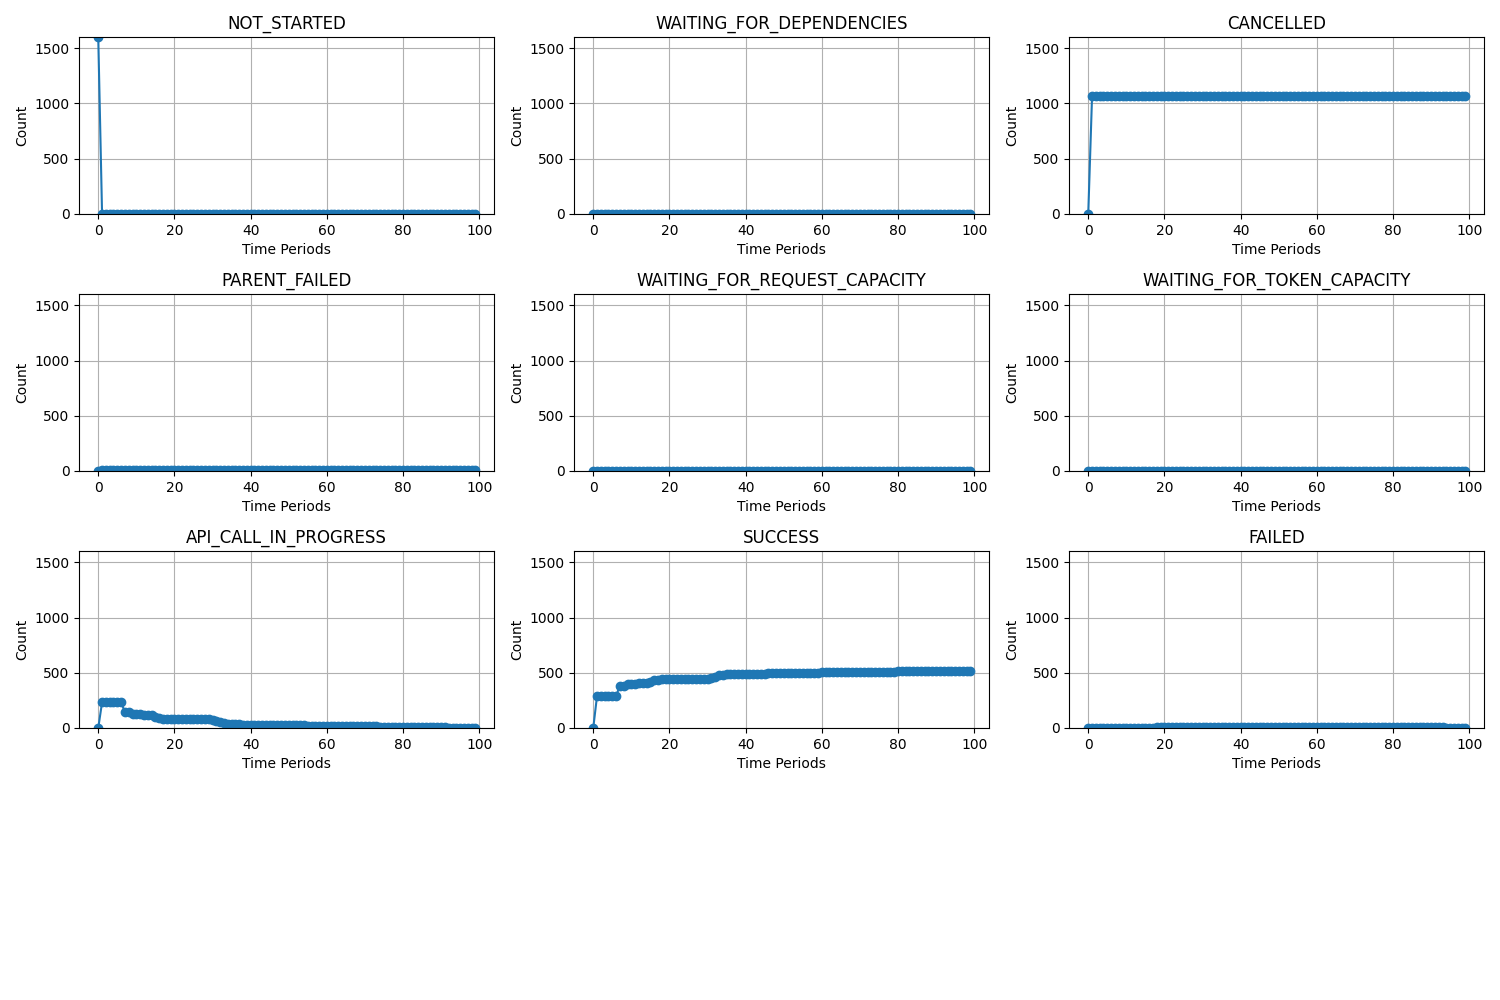

Also see: https://docs.expectedparrot.com/en/latest/exceptions.html


In [14]:
results = survey.by(scenarios).run()

In [15]:
# results.show_exceptions()

### Inspecting results
EDSL comes with built-in tools for analyzing results. For example, we can see a list of all the components of the results and then select some to print in a table:

In [16]:
results.columns

['agent.agent_instruction',
 'agent.agent_name',
 'answer.client_performance',
 'answer.dialog',
 'answer.freelancer_performance',
 'answer.preliminary',
 'comment.client_performance_comment',
 'comment.dialog_comment',
 'comment.freelancer_performance_comment',
 'comment.preliminary_comment',
 'iteration.iteration',
 'model.frequency_penalty',
 'model.logprobs',
 'model.max_tokens',
 'model.model',
 'model.presence_penalty',
 'model.temperature',
 'model.top_logprobs',
 'model.top_p',
 'prompt.client_performance_system_prompt',
 'prompt.client_performance_user_prompt',
 'prompt.dialog_system_prompt',
 'prompt.dialog_user_prompt',
 'prompt.freelancer_performance_system_prompt',
 'prompt.freelancer_performance_user_prompt',
 'prompt.preliminary_system_prompt',
 'prompt.preliminary_user_prompt',
 'question_options.client_performance_question_options',
 'question_options.dialog_question_options',
 'question_options.freelancer_performance_question_options',
 'question_options.preliminary_q

Note that each question type (other than free text) automatically includes an additional "_comment" field where the model can add any commentary about its response to the question. This can be useful for qualitative analysis and running follow-on questions.

In [17]:
(
    results.select(
        "job_title",
        "freelancer_role",
        "client_performance",
        "client_performance_comment",
        "freelancer_performance",
        "freelancer_performance_comment",
    ).print(format="rich")
)

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ scenario         ┃ scenario         ┃ answer           ┃ answer           ┃ comment          ┃ comment          ┃
┃ .job_title       ┃ .freelancer_role ┃ .client_perform… ┃ .freelancer_per… ┃ .client_perform… ┃ .freelancer_per… ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Senior Full      │ Junior Web       │ None             │ None             │ None             │ None             │
│ Stack Developer  │ Developer        │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Android          │ UX/UI Designer   │ None             │ None             │ None             │ None             │
│ Developer        │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Senior Full      │ iOS Developer    │ None             │ None             │ None             │ None             │
│ Stack Developer  │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Python Developer │ iOS Developer    │ None             │ None             │ None             │ None             │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ iOS Developer    │ Data Scientist   │ None             │ None             │ None             │ None             │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Cybersecurity    │ Data Scientist   │ None             │ None             │ None             │ None             │
│ Specialist       │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ iOS Developer    │ Database         │ None             │ None             │ None             │ None             │
│                  │ Administrator    │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Machine Learning │ Junior Web       │ None             │ None             │ None             │ None             │
│ Engineer         │ Developer        │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Senior Full      │ Junior Software  │ None             │ None             │ None             │ None             │
│ Stack Developer  │ Engineer         │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Senior Java      │ Cybersecurity    │ None             │ None             │ None             │ None             │
│ Developer        │ Specialist       │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Machine Learning │ UX/UI Designer   │ None             │ None             │ None             │ None             │
│ Engineer         │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼─────────────────

## Using AI Agents
In the second iteration of this experiment we construct agents representing a client and freelancers, tell them that they were the participants in the dialogs, and then prompt them to rate each other. This is different from the first experiment where we instructed the model to draft the dialog and then pretend to be either the client or freelancer with knowledge that it had created the dialog. This time, we simply give the dialog to the agents representing the client and freelancers and then instruct them to do the ratings.

### Accessing the dialogs
We start by transforming the results of the prior survey into a dataframe, so that we can easily access the scenarios (job posts and freelancer details) together with the dialogs that were generated. These will become the inputs to our new survey questions:

In [18]:
df = results.to_pandas(
    remove_prefix=True
)  # We can remove the 'agent.', 'answer.', etc. prefixes for convenience

We can inspect the dataframe and select the columns that we need:

In [19]:
df[
    [
        "preliminary",
        "dialog",
        "job_title",
        "job_details",
        "freelancer_role",
        "freelancer_experience",
    ]
]

preliminary                                             dialog  \
0            No                                                NaN   
1            No                                                NaN   
2            No                                                NaN   
3            No                                                NaN   
4            No                                                NaN   
..          ...                                                ...   
395         Yes  Interviewer: Good morning, Carol. It's great t...   
396         Yes                                                NaN   
397         Yes  Interviewer: Hello Bob, thanks for joining us ...   
398         Yes  Interviewer: Thank you for joining us today, J...   
399         Yes                                                NaN   

                       job_title  \
0    Senior Full Stack Developer   
1              Android Developer   
2    Senior Full Stack Developer   
3               Python Developer   
4                  iOS Developer   
..                           ...   
395     Junior Software Engineer   
396        Senior Java Developer   
397   Junior Front-End Developer   
398    Machine Learning Engineer   
399      Ruby on Rails Developer   

                                           job_details  \
0    Seeking a senior full stack developer to lead ...   
1    Looking for an Android developer with a strong...   
2    Seeking a senior full stack developer to lead ...   
3    Need a Python developer to build backend servi...   
4    We need an experienced iOS developer to create...   
..                                                 ...   
395  Looking for a junior software engineer to assi...   
396  Seeking a senior Java developer to design and ...   
397  We are looking for a junior front-end develope...   
398  We need a machine learning engineer to develop...   
399  Seeking a Ruby on Rails developer to create ne...   

                 freelancer_role  \
0           Junior Web Developer   
1                 UX/UI Designer   
2                  iOS Developer   
3                  iOS Developer   
4                 Data Scientist   
..                           ...   
395                iOS Developer   
396        Senior Java Developer   
397  Senior Full Stack Developer   
398    Machine Learning Engineer   
399      Ruby on Rails Developer   

                                 freelancer_experience  
0    Alice is a recent computer science graduate wi...  
1    Noah is a UX/UI designer with a strong backgro...  
2    Carol is an experienced iOS developer with a s...  
3    Carol is an experienced iOS developer with a s...  
4    Olivia is a data scientist with expertise in a...  
..                                                 ...  
395  Carol is an experienced iOS developer with a s...  
396  Quinn is a senior Java developer with over 8 y...  
397  Bob has over 10 years of experience in full st...  
398  Jack is a machine learning engineer with exper...  
399  Hank is a skilled Ruby on Rails developer with...  

[400 rows x 6 columns]

Next we create a client agent and freelancer agent for each combination of job post, freelancer and dialog in the original results, prompt them to rate the other party in the dialog, and compile the results:

Exceptions were raised in 1 out of 1 interviews.




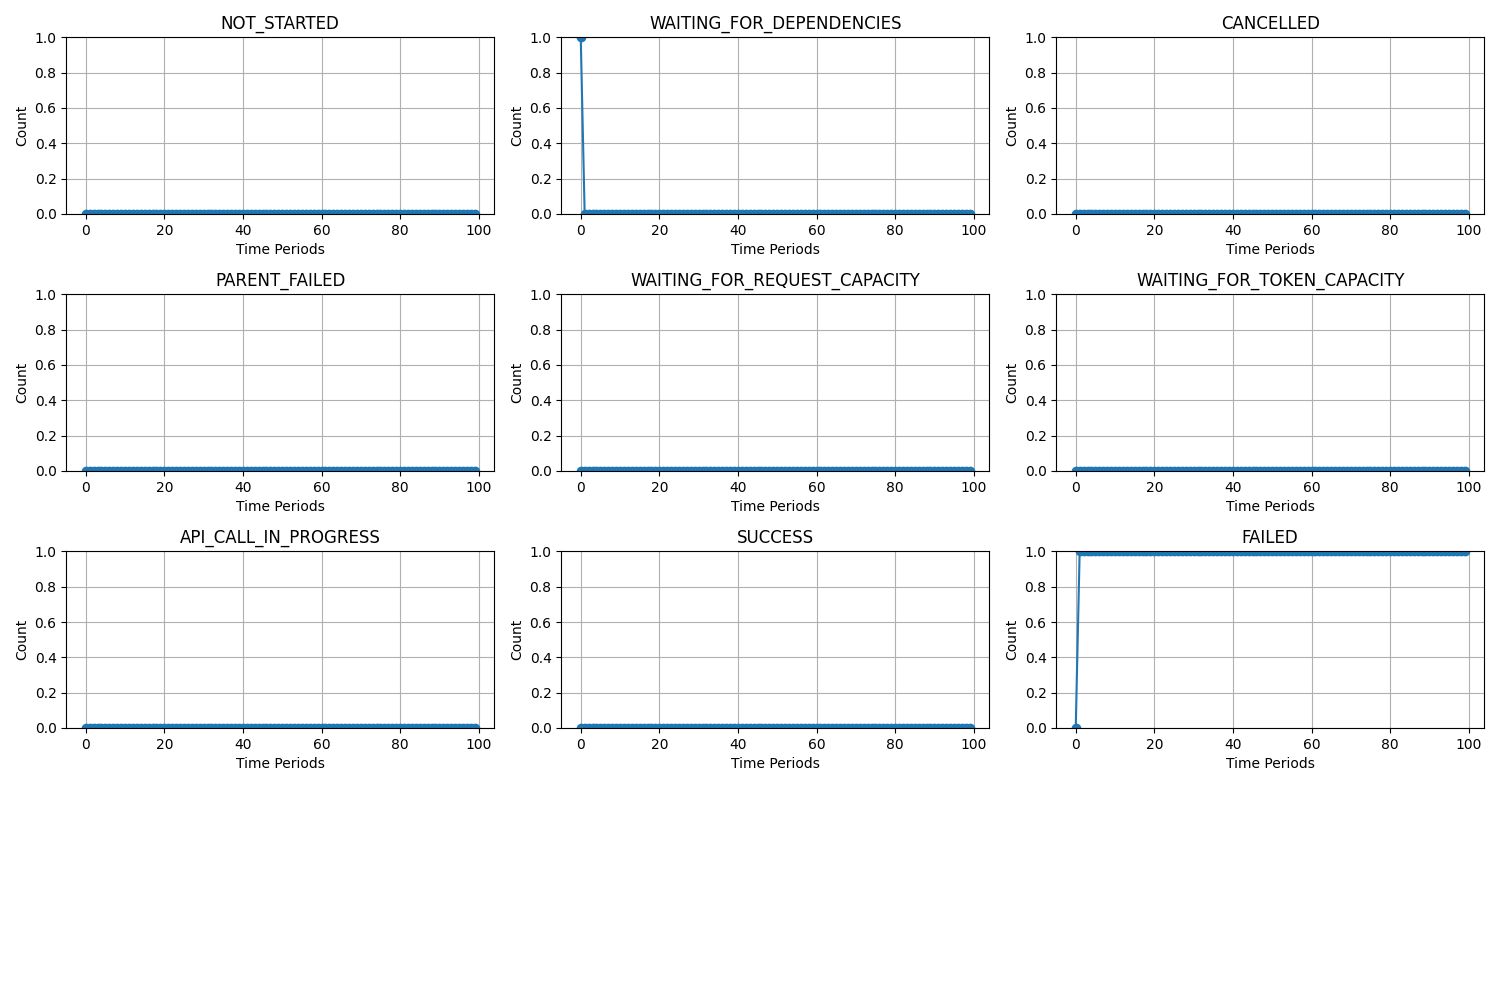

Also see: https://docs.expectedparrot.com/en/latest/exceptions.html
Exceptions were raised in 1 out of 1 interviews.




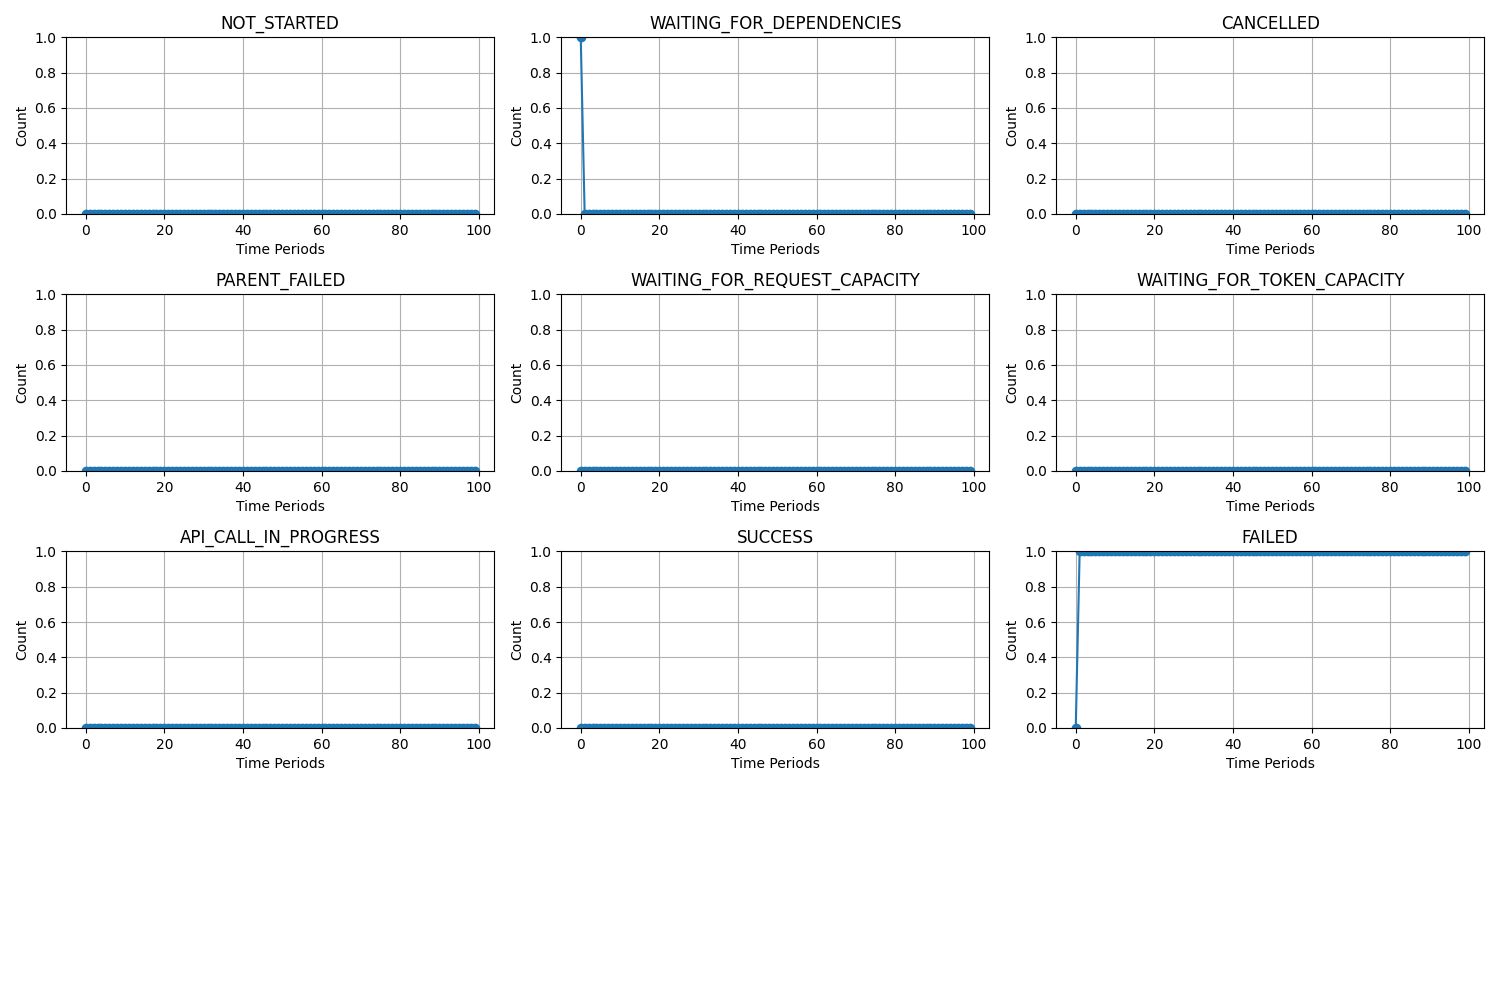

Also see: https://docs.expectedparrot.com/en/latest/exceptions.html
Exceptions were raised in 1 out of 1 interviews.




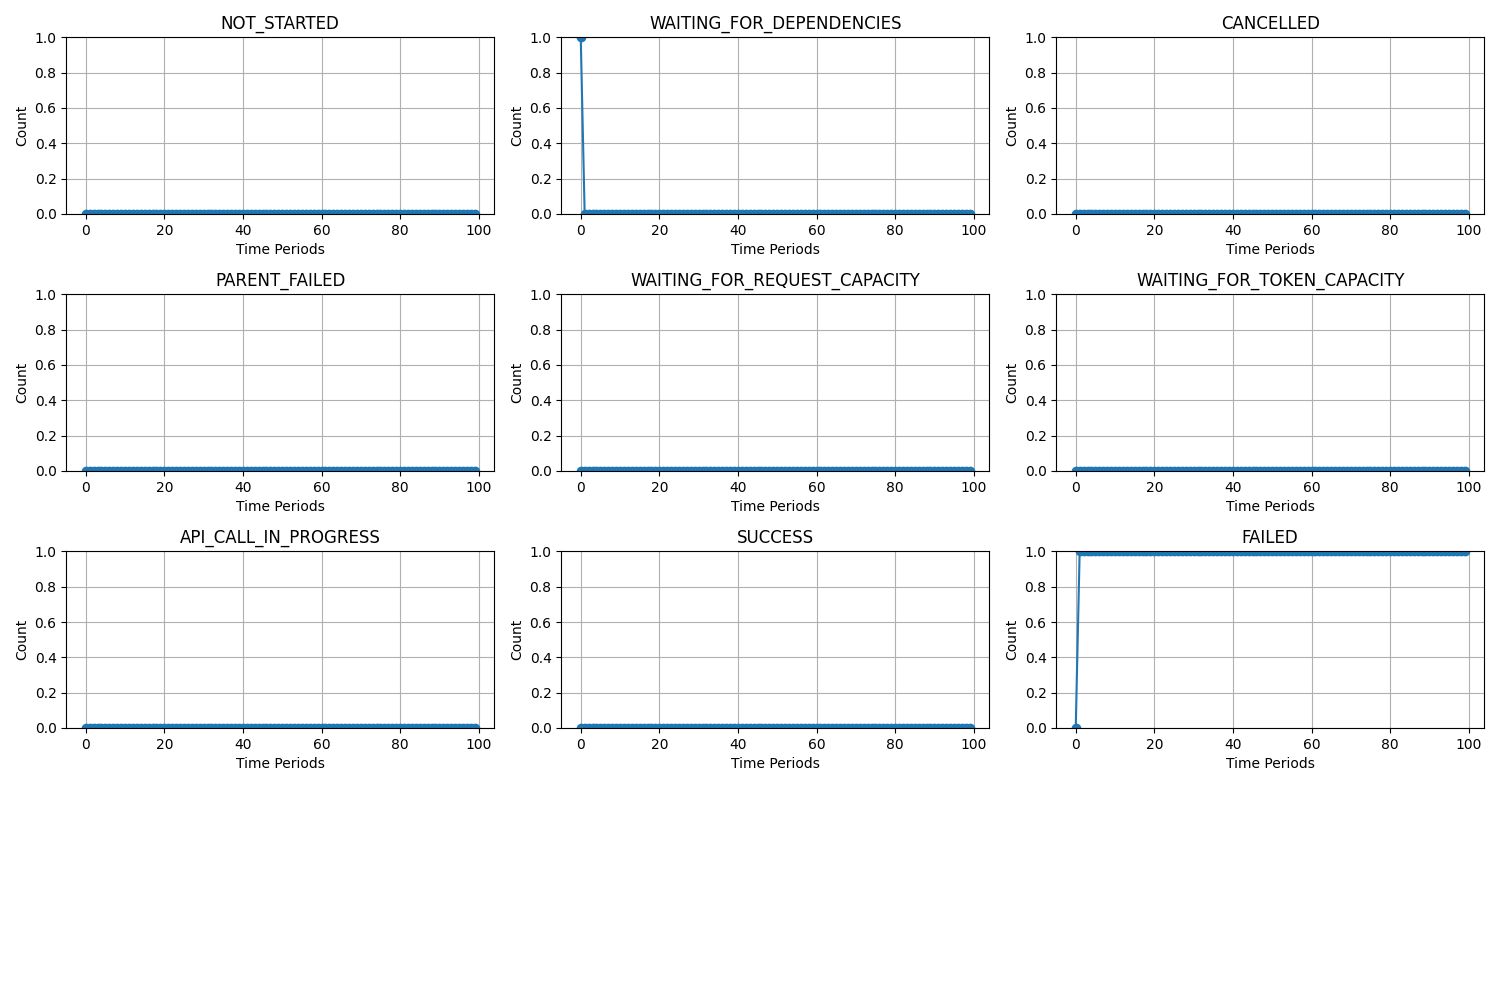

Also see: https://docs.expectedparrot.com/en/latest/exceptions.html
Exceptions were raised in 1 out of 1 interviews.




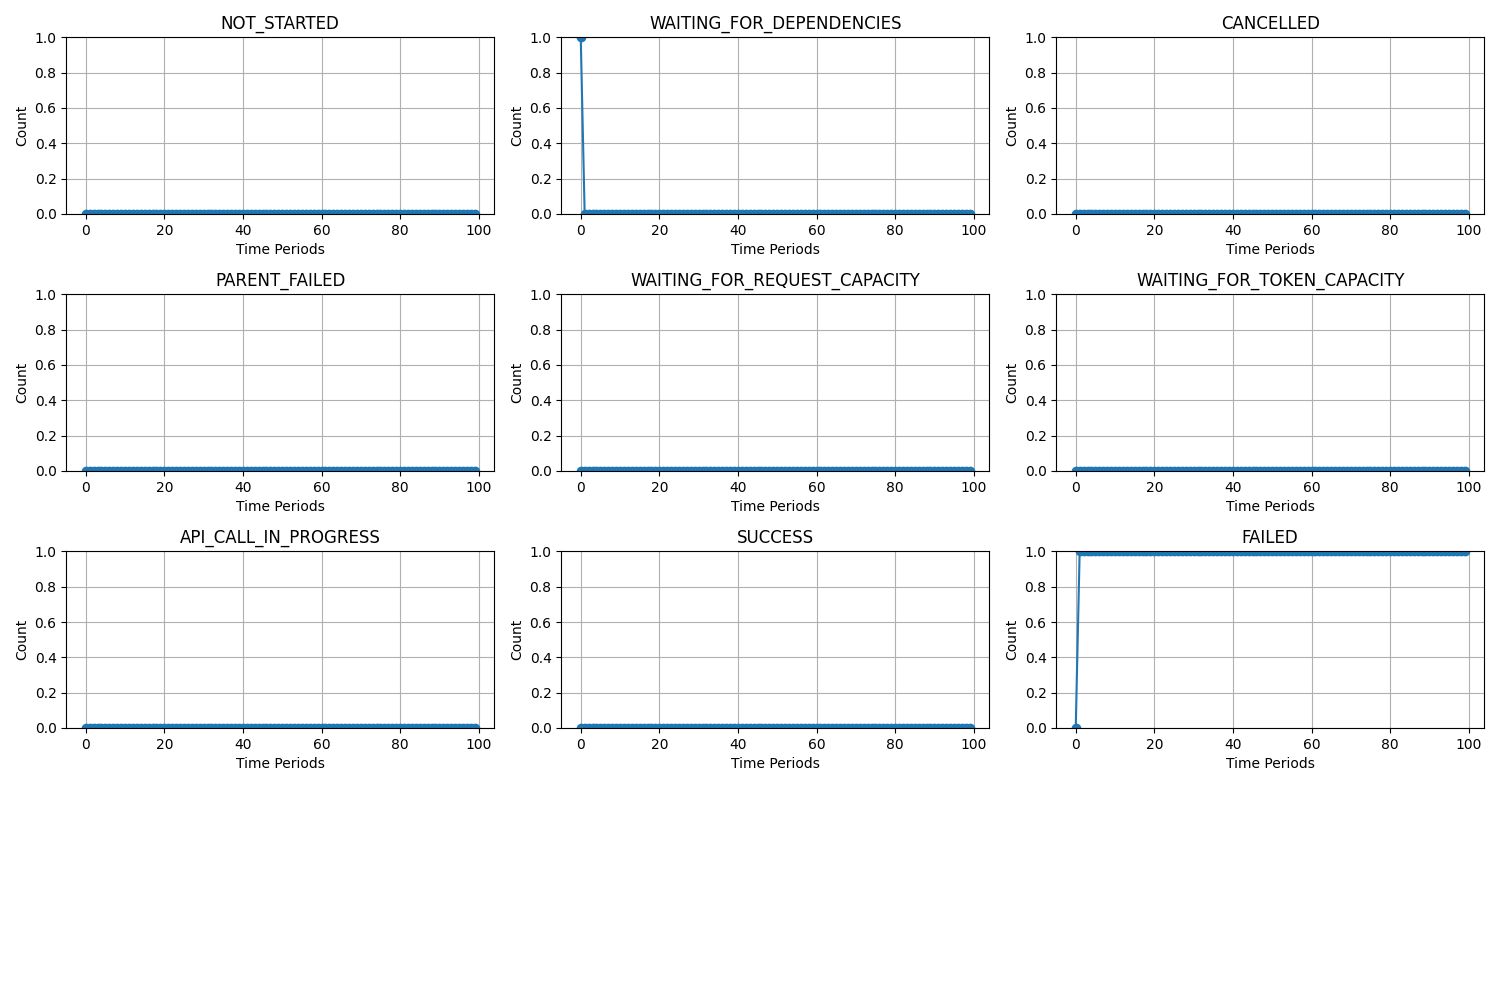

Also see: https://docs.expectedparrot.com/en/latest/exceptions.html
Exceptions were raised in 1 out of 1 interviews.




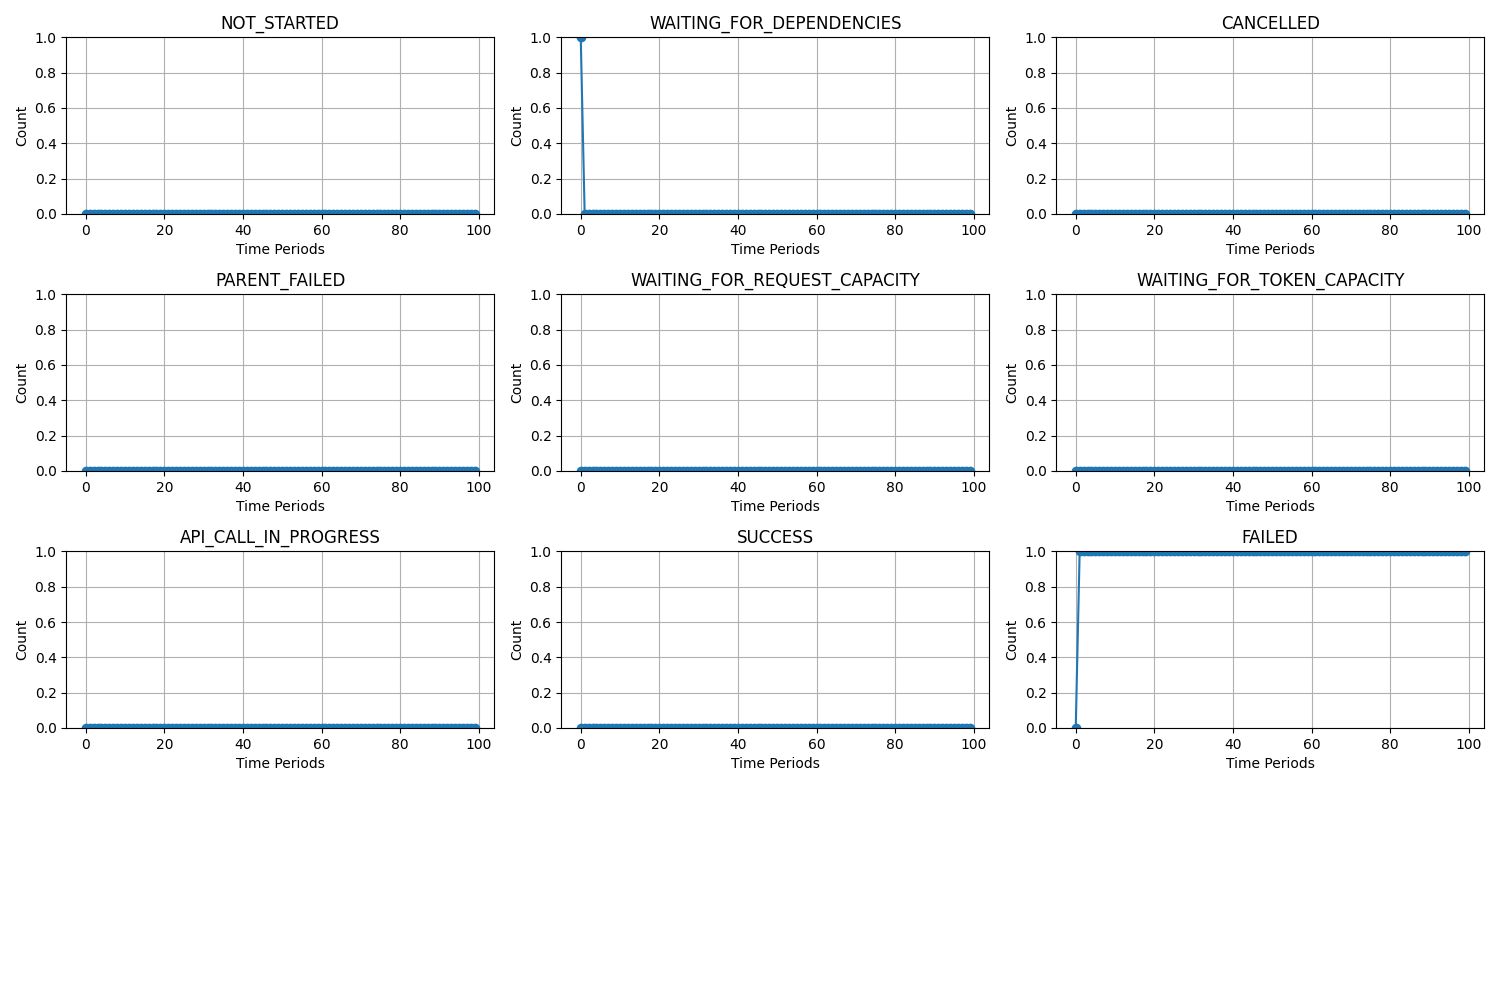

Also see: https://docs.expectedparrot.com/en/latest/exceptions.html
Exceptions were raised in 1 out of 1 interviews.




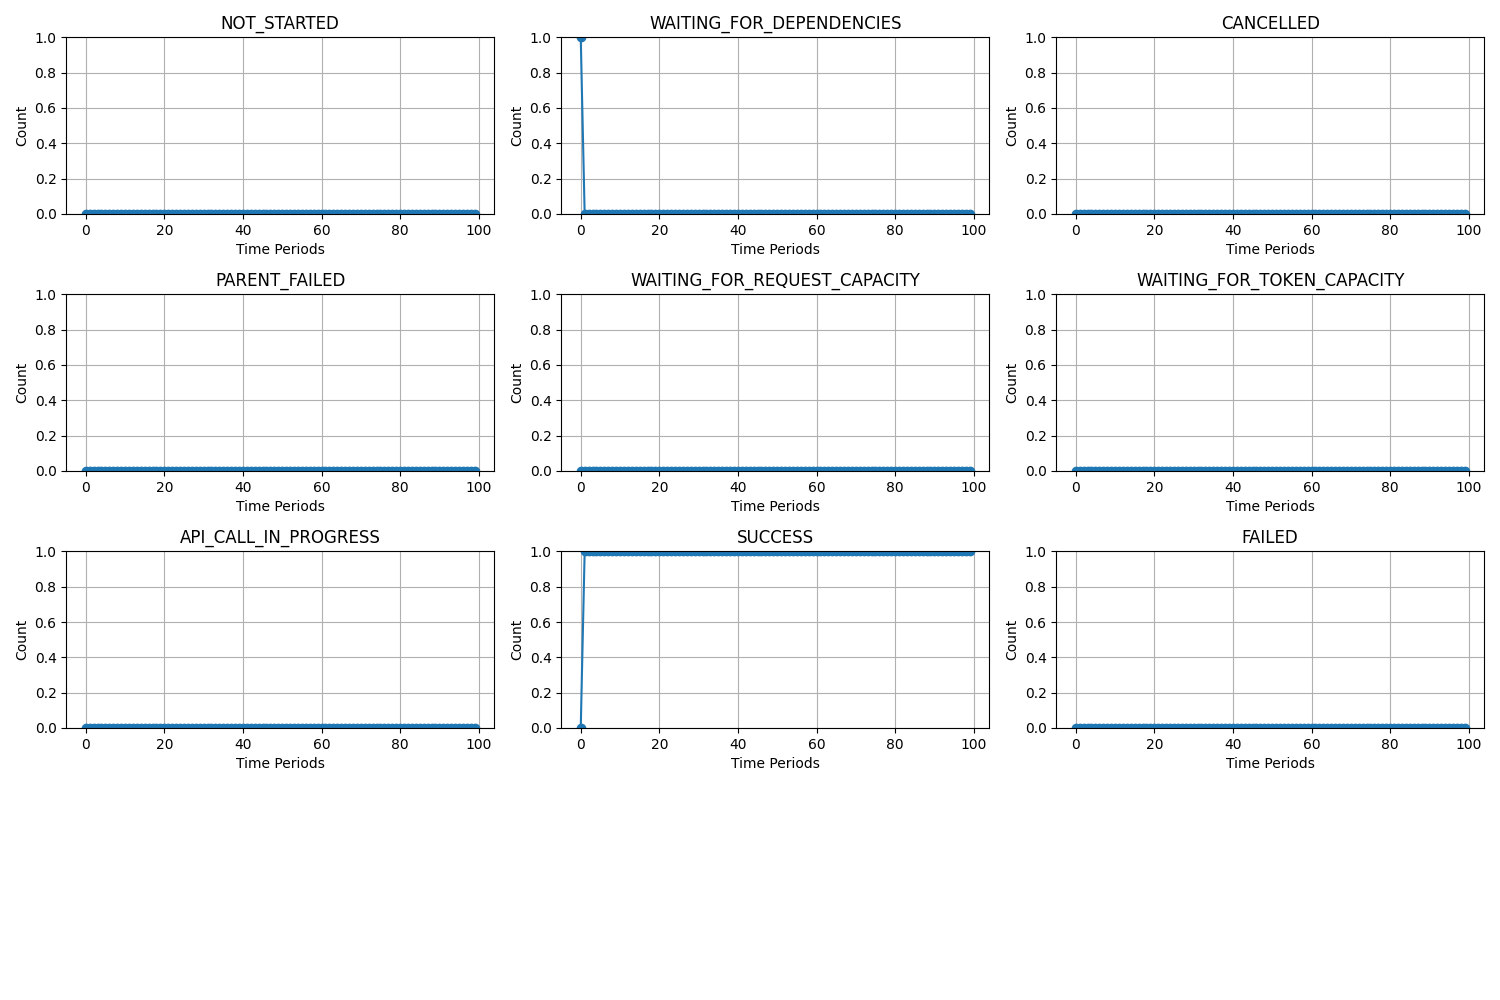

Also see: https://docs.expectedparrot.com/en/latest/exceptions.html


In [20]:
# Base personas for the agents
client_persona = "You are a client interviewing freelancers for jobs."
freelancer_persona = "You are a freelancer applying for a jobs."

# The sets of ratings results
client_performances = None
freelancer_performances = None

# Iterate through the job post/freelancer/dialog results to create agents and administer the questions
for index, row in df.iterrows():

    if row["preliminary"] == "Yes":  # Skip results where the dialog was not created

        job_title = row["job_title"]
        job_details = row["job_details"]

        # Each client agent has the base persona and instructions noting the job post title and details for the dialog
        client = Agent(
            traits={"persona": client_persona},
            instruction=f"""You are interviewing a freelancer for a job post: {job_title}
            Description: {job_details}""",
        )

        # Each freelancer agent has the base persona and freelancer details for the dialog
        freelancer = Agent(
            traits={
                "persona": freelancer_persona,
                "freelancer_name": row["freelancer_name"],
                "freelancer_role": row["freelancer_role"],
                "freelancer_experience": row["freelancer_experience"],
            }
        )

        # Question prompting the client to rate the freelancer:
        q_freelancer_performance = QuestionLinearScale(
            question_name="freelancer_performance",
            question_text="""You have just interviewed a freelancer for a job.
            Review the transcript of the interview and then rate the freelancer's  
            performance on a scale from 0 to 10: {{ dialog }}""",
            question_options=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            option_labels={0: "Terrible", 10: "Fantastic"},
        )

        # Question prompting the freelancer to rate the client
        q_client_performance = QuestionLinearScale(
            question_name="client_performance",
            question_text="""You have just been interviewed for a job.
            Review the transcript of the interview and then rate the client's  
            performance on a scale from 0 to 10: {{ dialog }}""",
            question_options=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            option_labels={0: "Terrible", 10: "Fantastic"},
        )

        # Parameterize the questions with the dialogs and add metadata to include with results
        scenario = Scenario(
            {
                "job_title": row["job_title"],
                "job_details": row["job_details"],
                "freelancer_name": row["freelancer_name"],
                "freelancer_role": row["freelancer_role"],
                "freelancer_experience": row["freelancer_experience"],
                "dialog": row["dialog"],
            }
        )

        # Generating the client performance rating by freelancer and adding it to the results
        if client_performances == None:
            client_performances = q_client_performance.by(freelancer).by(scenario).run()
        else:
            new_results = q_client_performance.by(freelancer).by(scenario).run()
            client_performances = client_performances + new_results

        # Generating the freelancer performance rating by client and adding it to the results
        if freelancer_performances == None:
            freelancer_performances = (
                q_freelancer_performance.by(client).by(scenario).run()
            )
        else:
            new_results = q_freelancer_performance.by(client).by(scenario).run()
            freelancer_performances = freelancer_performances + new_results

We can use dataframes to compare the results side-by-side for each dialog:

In [21]:
df_client = client_performances.to_pandas(remove_prefix=True)
df_freelancer = freelancer_performances.to_pandas(remove_prefix=True)

In [22]:
common_columns = [
    "job_title",
    "job_details",
    "freelancer_name",
    "freelancer_role",
    "freelancer_experience",
    "dialog",
]

In [23]:
df_combined = pd.merge(
    df_client,
    df_freelancer,
    how="inner",
    left_on=common_columns,
    right_on=common_columns,
)

In [24]:
df_combined.columns

Index(['agent_instruction_x', 'agent_name_x', 'client_performance',
       'client_performance_comment', 'client_performance_question_options',
       'client_performance_question_text', 'client_performance_question_type',
       'client_performance_raw_model_response',
       'client_performance_system_prompt', 'client_performance_user_prompt',
       'dialog', 'edsl_class_name_x', 'edsl_version_x',
       'freelancer_experience', 'freelancer_name', 'freelancer_role',
       'frequency_penalty_x', 'iteration_x', 'job_details', 'job_title',
       'logprobs_x', 'max_tokens_x', 'model_x', 'persona_x',
       'presence_penalty_x', 'temperature_x', 'top_logprobs_x', 'top_p_x',
       'agent_instruction_y', 'agent_name_y', 'edsl_class_name_y',
       'edsl_version_y', 'freelancer_performance',
       'freelancer_performance_comment',
       'freelancer_performance_question_options',
       'freelancer_performance_question_text',
       'freelancer_performance_question_type',
       'freela

In [25]:
df_combined[
    [
        "job_title",
        "freelancer_role",
        "client_performance",
        "client_performance_comment",
        "freelancer_performance",
        "freelancer_performance_comment",
    ]
]

job_title              freelancer_role  \
0             Android Developer            Android Developer   
1     Cloud Solutions Architect              DevOps Engineer   
2                Game Developer               Game Developer   
3          Junior Web Developer   Junior Front-End Developer   
4      Junior Software Engineer    Machine Learning Engineer   
5     Machine Learning Engineer               Data Scientist   
6                Data Scientist               Data Scientist   
7   Senior Full Stack Developer  Senior Full Stack Developer   
8              Python Developer    Machine Learning Engineer   
9                 iOS Developer                iOS Developer   
10      Ruby on Rails Developer       Database Administrator   
11       Database Administrator             Python Developer   
12               UX/UI Designer               UX/UI Designer   
13            Backend Developer  Senior Full Stack Developer   
14     Junior Software Engineer     Junior Software Engineer   
15         Junior Web Developer         Junior Web Developer   
16         Junior Web Developer         Mobile App Developer   
17               Data Scientist             Python Developer   
18         Junior Web Developer  Senior Full Stack Developer   
19              DevOps Engineer              DevOps Engineer   
20   Junior Front-End Developer         Junior Web Developer   
21     Junior Software Engineer            Android Developer   
22     Junior Software Engineer         Mobile App Developer   
23   Junior Front-End Developer   Junior Front-End Developer   
24    Cloud Solutions Architect    Cloud Solutions Architect   
25         Blockchain Developer         Blockchain Developer   
26     Junior Software Engineer               Game Developer   
27         Mobile App Developer         Mobile App Developer   
28         Junior Web Developer        Senior Java Developer   
29     Cybersecurity Specialist     Cybersecurity Specialist   
30             Python Developer             Python Developer   
31            Backend Developer            Backend Developer   
32     Junior Software Engineer  Senior Full Stack Developer   
33     Cybersecurity Specialist    Cloud Solutions Architect   
34       Database Administrator       Database Administrator   
35     Junior Software Engineer        Senior Java Developer   
36               Data Scientist    Machine Learning Engineer   
37       Database Administrator  Senior Full Stack Developer   
38              DevOps Engineer    Cloud Solutions Architect   
39     Junior Software Engineer                iOS Developer   
40        Senior Java Developer        Senior Java Developer   
41   Junior Front-End Developer  Senior Full Stack Developer   
42    Machine Learning Engineer    Machine Learning Engineer   
43      Ruby on Rails Developer      Ruby on Rails Developer   

    client_performance                         client_performance_comment  \
0                  8.0  The interviewer conducted a focused and releva...   
1                  8.0  The interviewer conducted a focused and releva...   
2                  8.0  The interviewer conducted a focused and releva...   
3                  8.0  The interviewer conducted a structured and rel...   
4                  8.0  The interviewer conducted a professional and f...   
5                  9.0  The interviewer conducted a structured and foc...   
6                  8.0  The interviewer conducted a professional inter...   
7                  9.0  The interviewer conducted a professional and f...   
8                  9.0  The interviewer conducted a focused and releva...   
9                  9.0  The client conducted a thorough and profession...   
10                 8.0  The interviewer was polite and clear with thei...   
11                 9.0  The interviewer conducted a structured and rel...   
12                 9.0  The interviewer conducted a professional and f...   
13                 9.0  The interviewer conducted a professiona

## Heatmaps

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

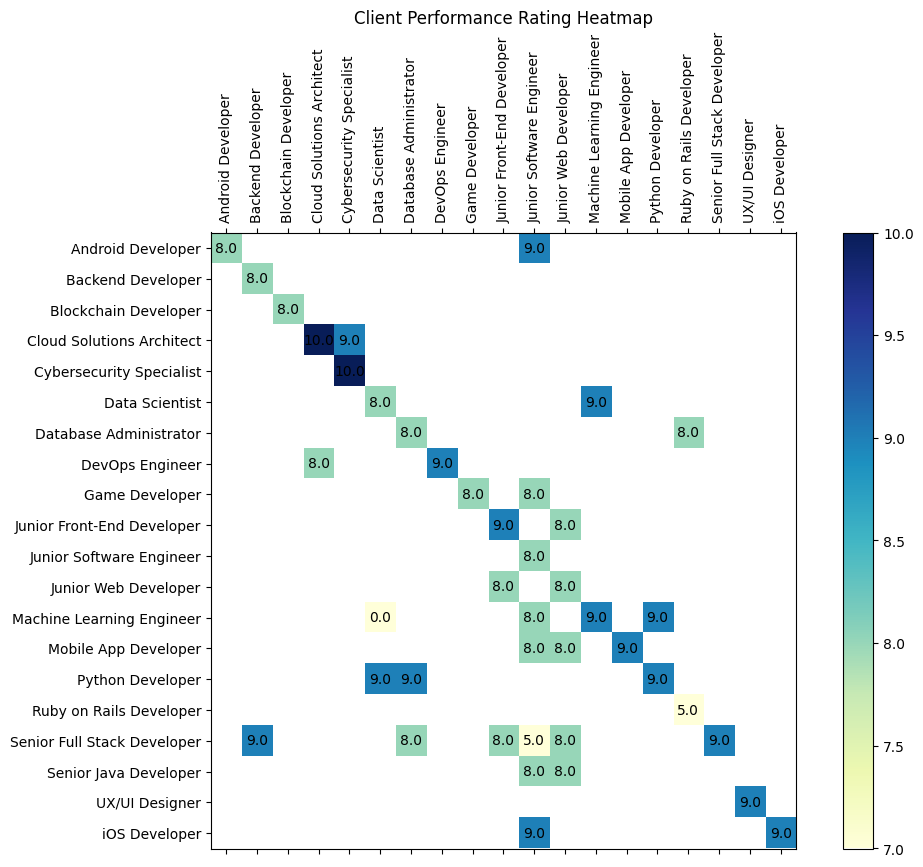

In [27]:
# Pivot table for the heatmap
client_performance_matrix = df_combined.pivot_table(
    index="freelancer_role", columns="job_title", values="client_performance"
)

# Set min and max heat values
vmin = 7  # Replace with your minimum value
vmax = 10  # Replace with your maximum value

fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(client_performance_matrix, cmap="YlGnBu", vmin=vmin, vmax=vmax)
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(client_performance_matrix.columns)))
ax.set_yticks(np.arange(len(client_performance_matrix.index)))
ax.set_xticklabels(client_performance_matrix.columns)
ax.set_yticklabels(client_performance_matrix.index)

# Rotate the x labels for better readability
plt.xticks(rotation=90)

# Annotate the heatmap
for i in range(client_performance_matrix.shape[0]):
    for j in range(client_performance_matrix.shape[1]):
        value = client_performance_matrix.iloc[i, j]
        ax.text(
            j,
            i,
            f"{value:.1f}" if not np.isnan(value) else "",
            ha="center",
            va="center",
        )

plt.title("Client Performance Rating Heatmap")
plt.show()

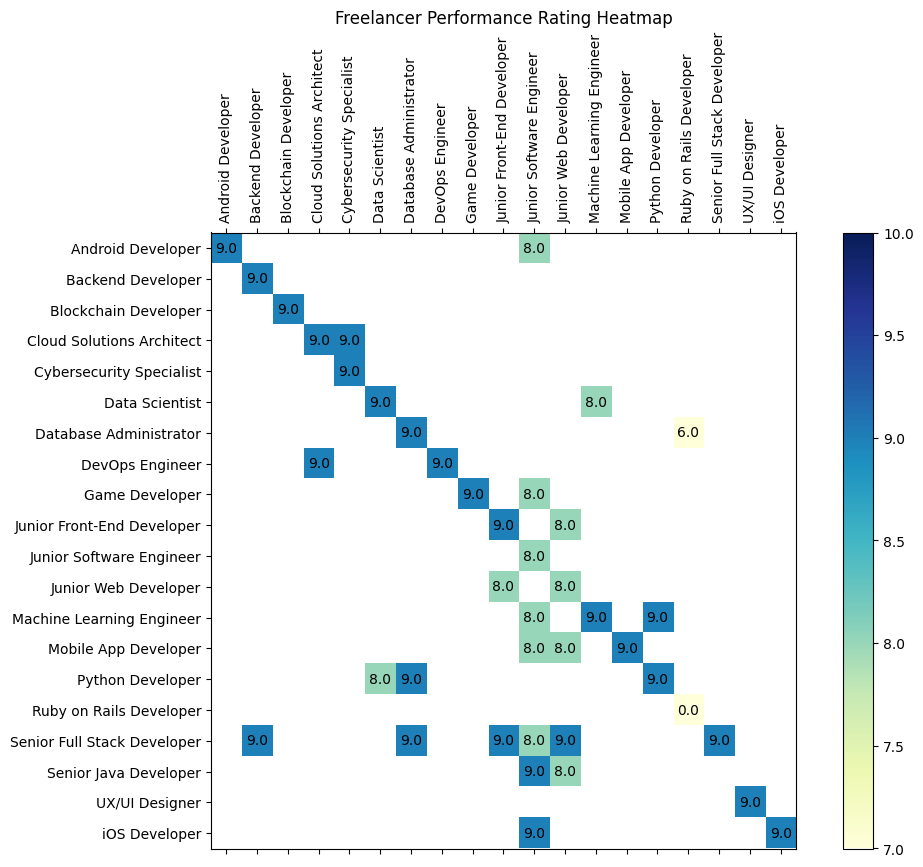

In [28]:
# Pivot table for the heatmap
freelancer_performance_matrix = df_combined.pivot_table(
    index="freelancer_role", columns="job_title", values="freelancer_performance"
)

# Set min and max heat values
vmin = 7  # Replace with your minimum value
vmax = 10  # Replace with your maximum value

fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(freelancer_performance_matrix, cmap="YlGnBu", vmin=vmin, vmax=vmax)
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(freelancer_performance_matrix.columns)))
ax.set_yticks(np.arange(len(freelancer_performance_matrix.index)))
ax.set_xticklabels(freelancer_performance_matrix.columns)
ax.set_yticklabels(freelancer_performance_matrix.index)

# Rotate the x labels for better readability
plt.xticks(rotation=90)

# Annotate the heatmap
for i in range(freelancer_performance_matrix.shape[0]):
    for j in range(freelancer_performance_matrix.shape[1]):
        value = freelancer_performance_matrix.iloc[i, j]
        ax.text(
            j,
            i,
            f"{value:.1f}" if not np.isnan(value) else "",
            ha="center",
            va="center",
        )

plt.title("Freelancer Performance Rating Heatmap")
plt.show()

In [29]:
client_performance_matrix

job_title                    Android Developer  Backend Developer  \
freelancer_role                                                     
Android Developer                          8.0                NaN   
Backend Developer                          NaN                8.0   
Blockchain Developer                       NaN                NaN   
Cloud Solutions Architect                  NaN                NaN   
Cybersecurity Specialist                   NaN                NaN   
Data Scientist                             NaN                NaN   
Database Administrator                     NaN                NaN   
DevOps Engineer                            NaN                NaN   
Game Developer                             NaN                NaN   
Junior Front-End Developer                 NaN                NaN   
Junior Software Engineer                   NaN                NaN   
Junior Web Developer                       NaN                NaN   
Machine Learning Engineer                  NaN                NaN   
Mobile App Developer                       NaN                NaN   
Python Developer                           NaN                NaN   
Ruby on Rails Developer                    NaN                NaN   
Senior Full Stack Developer                NaN                9.0   
Senior Java Developer                      NaN                NaN   
UX/UI Designer                             NaN                NaN   
iOS Developer                              NaN                NaN   

job_title                    Blockchain Developer  Cloud Solutions Architect  \
freelancer_role                                                                
Android Developer                             NaN                        NaN   
Backend Developer                             NaN                        NaN   
Blockchain Developer                          8.0                        NaN   
Cloud Solutions Architect                     NaN                       10.0   
Cybersecurity Specialist                      NaN                        NaN   
Data Scientist                                NaN                        NaN   
Database Administrator                        NaN                        NaN   
DevOps Engineer                               NaN                        8.0   
Game Developer                                NaN                        NaN   
Junior Front-End Developer                    NaN                        NaN   
Junior Software Engineer                      NaN                        NaN   
Junior Web Developer                          NaN                        NaN   
Machine Learning Engineer                     NaN                        NaN   
Mobile App Developer                          NaN                        NaN   
Python Developer                              NaN                        NaN   
Ruby on Rails Developer                       NaN                        NaN   
Senior Full Stack Developer                   NaN                        NaN   
Senior Java Developer                         NaN                        NaN   
UX/UI Designer                                NaN                        NaN   
iOS Developer                                 NaN                        NaN   

job_title                    Cybersecurity Specialist  Data Scientist  \
freelancer_role                                                         
Android Developer                                 NaN             NaN   
Backend Developer                                 NaN             NaN   
Blockchain Developer                              NaN             NaN   
Cloud Solutions Architect                         9.0             NaN   
Cybersecurity Specialist                         10.0             NaN   
Data Scientist                                    NaN             8.0   
Database Administrator                            NaN             NaN   
DevOps Engineer                                   NaN          

In [30]:
freelancer_performance_matrix

job_title                    Android Developer  Backend Developer  \
freelancer_role                                                     
Android Developer                          9.0                NaN   
Backend Developer                          NaN                9.0   
Blockchain Developer                       NaN                NaN   
Cloud Solutions Architect                  NaN                NaN   
Cybersecurity Specialist                   NaN                NaN   
Data Scientist                             NaN                NaN   
Database Administrator                     NaN                NaN   
DevOps Engineer                            NaN                NaN   
Game Developer                             NaN                NaN   
Junior Front-End Developer                 NaN                NaN   
Junior Software Engineer                   NaN                NaN   
Junior Web Developer                       NaN                NaN   
Machine Learning Engineer                  NaN                NaN   
Mobile App Developer                       NaN                NaN   
Python Developer                           NaN                NaN   
Ruby on Rails Developer                    NaN                NaN   
Senior Full Stack Developer                NaN                9.0   
Senior Java Developer                      NaN                NaN   
UX/UI Designer                             NaN                NaN   
iOS Developer                              NaN                NaN   

job_title                    Blockchain Developer  Cloud Solutions Architect  \
freelancer_role                                                                
Android Developer                             NaN                        NaN   
Backend Developer                             NaN                        NaN   
Blockchain Developer                          9.0                        NaN   
Cloud Solutions Architect                     NaN                        9.0   
Cybersecurity Specialist                      NaN                        NaN   
Data Scientist                                NaN                        NaN   
Database Administrator                        NaN                        NaN   
DevOps Engineer                               NaN                        9.0   
Game Developer                                NaN                        NaN   
Junior Front-End Developer                    NaN                        NaN   
Junior Software Engineer                      NaN                        NaN   
Junior Web Developer                          NaN                        NaN   
Machine Learning Engineer                     NaN                        NaN   
Mobile App Developer                          NaN                        NaN   
Python Developer                              NaN                        NaN   
Ruby on Rails Developer                       NaN                        NaN   
Senior Full Stack Developer                   NaN                        NaN   
Senior Java Developer                         NaN                        NaN   
UX/UI Designer                                NaN                        NaN   
iOS Developer                                 NaN                        NaN   

job_title                    Cybersecurity Specialist  Data Scientist  \
freelancer_role                                                         
Android Developer                                 NaN             NaN   
Backend Developer                                 NaN             NaN   
Blockchain Developer                              NaN             NaN   
Cloud Solutions Architect                         9.0             NaN   
Cybersecurity Specialist                          9.0             NaN   
Data Scientist                                    NaN             9.0   
Database Administrator                            NaN             NaN   
DevOps Engineer                                   NaN          

In [31]:
freelancer_performance_matrix.fillna(-1, inplace=True)

In [32]:
freelancer_performance_matrix

job_title                    Android Developer  Backend Developer  \
freelancer_role                                                     
Android Developer                          9.0               -1.0   
Backend Developer                         -1.0                9.0   
Blockchain Developer                      -1.0               -1.0   
Cloud Solutions Architect                 -1.0               -1.0   
Cybersecurity Specialist                  -1.0               -1.0   
Data Scientist                            -1.0               -1.0   
Database Administrator                    -1.0               -1.0   
DevOps Engineer                           -1.0               -1.0   
Game Developer                            -1.0               -1.0   
Junior Front-End Developer                -1.0               -1.0   
Junior Software Engineer                  -1.0               -1.0   
Junior Web Developer                      -1.0               -1.0   
Machine Learning Engineer                 -1.0               -1.0   
Mobile App Developer                      -1.0               -1.0   
Python Developer                          -1.0               -1.0   
Ruby on Rails Developer                   -1.0               -1.0   
Senior Full Stack Developer               -1.0                9.0   
Senior Java Developer                     -1.0               -1.0   
UX/UI Designer                            -1.0               -1.0   
iOS Developer                             -1.0               -1.0   

job_title                    Blockchain Developer  Cloud Solutions Architect  \
freelancer_role                                                                
Android Developer                            -1.0                       -1.0   
Backend Developer                            -1.0                       -1.0   
Blockchain Developer                          9.0                       -1.0   
Cloud Solutions Architect                    -1.0                        9.0   
Cybersecurity Specialist                     -1.0                       -1.0   
Data Scientist                               -1.0                       -1.0   
Database Administrator                       -1.0                       -1.0   
DevOps Engineer                              -1.0                        9.0   
Game Developer                               -1.0                       -1.0   
Junior Front-End Developer                   -1.0                       -1.0   
Junior Software Engineer                     -1.0                       -1.0   
Junior Web Developer                         -1.0                       -1.0   
Machine Learning Engineer                    -1.0                       -1.0   
Mobile App Developer                         -1.0                       -1.0   
Python Developer                             -1.0                       -1.0   
Ruby on Rails Developer                      -1.0                       -1.0   
Senior Full Stack Developer                  -1.0                       -1.0   
Senior Java Developer                        -1.0                       -1.0   
UX/UI Designer                               -1.0                       -1.0   
iOS Developer                                -1.0                       -1.0   

job_title                    Cybersecurity Specialist  Data Scientist  \
freelancer_role                                                         
Android Developer                                -1.0            -1.0   
Backend Developer                                -1.0            -1.0   
Blockchain Developer                             -1.0            -1.0   
Cloud Solutions Architect                         9.0            -1.0   
Cybersecurity Specialist                          9.0            -1.0   
Data Scientist                                   -1.0             9.0   
Database Administrator                           -1.0            -1.0   
DevOps Engineer                                  -1.0          